# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

# *Credit and code attribution*

This is a school project from Udacity. A significant portion of the code is provided as a starting template. I also seeked help from the forums and chat channels. The idea of (and occasinally the whole function) of get_point_horizontal(), fitline(), using unit tests, and the bulk image writing all stem from there. A big thank you to everyone at Udacity for puttings this together and everyone on the forum for answering questions. I believe I gained a reasonable understanding of the pipeline flow and that the overall implemenation is my own.



**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [21]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


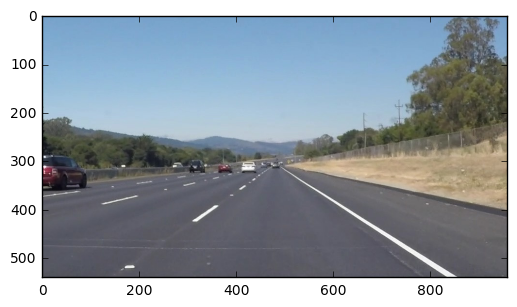

In [22]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

gray image shape: (540, 960)


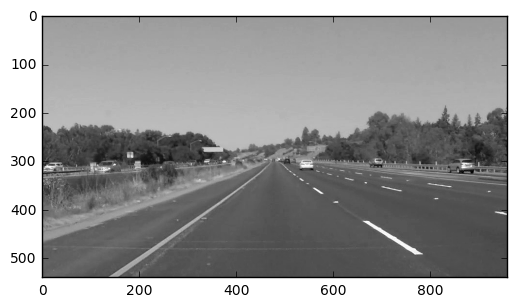

In [23]:
# test image for all unit tests
test_image = (mpimg.imread('test_images/solidYellowLeft.jpg'))

def grayscale(img):
    """Applies the Grayscale transform 
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    #gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

############## UNIT TEST ##############
gray = grayscale(test_image)
#this should be a single channel image shaped like(image.shape[0], image.shape[1])
print("gray image shape: {}".format(gray.shape))
plt.imshow(gray, cmap='gray');
############################

gaussian_blur_test shape: (540, 960)


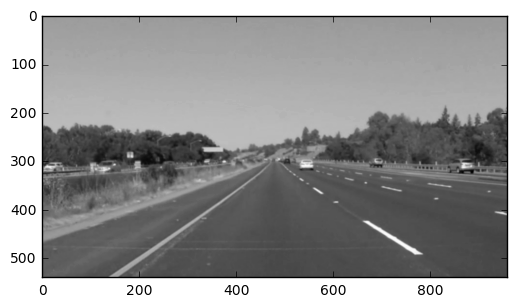

In [24]:
def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    
    gray_image = grayscale(img)
    
    return cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

############## UNIT TEST ##############
gaussian_blur_test = gaussian_blur(test_image)
 # this should still be a single channel image
print("gaussian_blur_test shape: {}".format(gaussian_blur_test.shape))
plt.imshow(gaussian_blur_test, cmap='gray');
######################

canny image shape


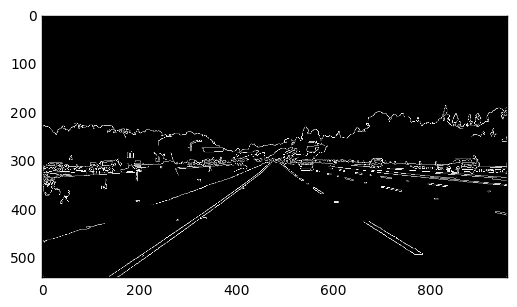

In [25]:
def canny(img, low_threshold=70, high_threshold=210):
    """Applies the Canny transform"""

    return cv2.Canny(img, low_threshold, high_threshold)

############## UNIT TEST ##############
test_edges = canny(test_image)
print("canny image shape".format(test_edges.shape)) 
# this should still be a singel channel image.
plt.imshow(test_edges, cmap='gray')
######################

masked_edges shape (540, 960)


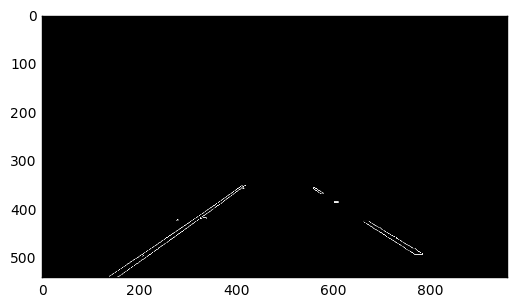

In [26]:
def region_of_interest(edges):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    #defining a blank mask to start with
    """    
    #Create a masked edges image
    mask = np.zeros_like(edges) 
    ignore_mask_color = 255
    
    # Define a four sided polygon to mask.
    # numpy.array returns a tuple of number of rows, columns and channels.
    imshape = edges.shape
    vertices = np.array([[(50,imshape[0]),(380, 350), (580, 350), (900,imshape[0])]], dtype=np.int32)
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_edges = cv2.bitwise_and(edges, mask)
    return masked_edges


############## UNIT TEST ##############
test_edges = canny(test_image)
masked_edges = region_of_interest(test_edges)
print("masked_edges shape {}".format(masked_edges.shape)) 
# again a single channel image
plt.imshow(masked_edges, cmap='gray')
######################

masked_edges shape (540, 960, 3)


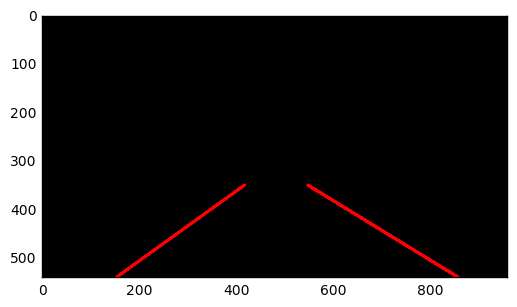

In [27]:
"""
After you separate them, calculate the average slope of the segments per lane. 
With that slope, decide on two Y coordinates where you want the lane lines to start and end 
(for example, use the bottom of the image as a Y_bottom point, and Y_top = 300 or something 
like that – where the horizon is). Now that you have your Y coordinates, calculate the 
X coordinates per lane line.
"""
# Helper variables for comparing and averaging values 
prev_left_top_x = prev_right_top_x = prev_right_bottom_x = prev_left_bottom_x = 0
all_left_top_x = all_right_top_x = all_right_bottom_x = all_left_bottom_x = [0]
all_left_top_x = np.array(all_left_top_x)
all_left_bottom_x = np.array(all_left_bottom_x)
all_right_top_x = np.array(all_right_top_x)
all_right_bottom_x = np.array(all_right_bottom_x)


def cruise_control (previous, current, factor):
    """
    Helper function for comparing current and previous values
    Uncomment print line to watch value differences it's kind of neat!
    """
    # print (previous, current, previous - current)
        
    difference = int(abs(previous) - abs(current))
    #print(difference)
    if difference <= factor:
        return current
    else:
        return previous


def get_point_horizontal( vx, vy, x1, y1, y_ref ):
    """
    Helper function for draw_lines
    Calculates 'x' matching: 2 points on a line, its slope, and a given 'y' coordinate.
    """
    m = vy / vx
    b = y1 - ( m * x1 )
    x = ( y_ref - b ) / m
    return x


def draw_lines(line_img, lines, color=[255, 0, 0], thickness=6):
    """
    average/extrapolate the line segments you detect to map out the full extent of the lane
    """
    right_segment_points = []
    left_segment_points = [] 
    top_y = 350
    bot_y = line_img.shape[0]
    smoothie = 6    #lower number = more discared frames.
    
    for line in lines:     
        for x1,y1,x2,y2 in line:
            
            # 1, find slope
            slope = float((y2-y1)/(x2-x1))
            # print (slope)
            max_slope_thresh = .85
            min_slope_thresh = .2
            
            # 2, use sloap to split lanes into left and right.
            # theory that a negative slope will be right lane
            if max_slope_thresh >= slope >= min_slope_thresh:
                
                # print (slope)
                # append all points to points array 
                right_segment_points.append([x1,y1])
                right_segment_points.append([x2,y2])
                
                # declare numpy array
                # fit a line with those points
                # TODO explore other options besides DIST_12
                # TODO compare to polyfit implementation
                right_segment = np.array(right_segment_points)
                [r_vx, r_vy, r_cx, r_cy] = cv2.fitLine(right_segment, cv2.DIST_L12, 0, 0.01, 0.01)
                
                # define 2 x points for right lane line
                right_top_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, top_y )
                right_bottom_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, bot_y )
                
            elif -max_slope_thresh <= slope <= -min_slope_thresh:
                
                # print (slope)
                # append all points to points array 
                left_segment_points.append([x1,y1])
                left_segment_points.append([x2,y2])
                
                # declare numpy array
                # fit a line with those points
                # TODO add something to test if segment points not blank
                left_segment = np.array(left_segment_points)
                [r_vx, r_vy, r_cx, r_cy] = cv2.fitLine(left_segment, cv2.DIST_L12, 0, 0.01, 0.01)
                
                # define 2 x points for left lane line
                left_top_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, top_y )
                left_bottom_x = get_point_horizontal( r_vx, r_vy, r_cx, r_cy, bot_y )
    
    #TODO split into lists to avoid so much repeat
    #TODO consider using Bayes ie Given frame thinks it's X, sensor .9 accurate, and past frame is Y 
    # what is chance in lane? and layer that logic on top of pixel difference 
    # (ie z chance or greater keep frame else reject frame)
    
    """
    These global functions acomplish two things:
    a) Averaging and weighting point values
    b) Discarding frames that are too far out of "normal" as defined by smoothie variable
    Smoothie compares absolute value difference between current and previous frame, in pixels,
    and if the current frame has a greater difference than smoothie variable, it uses the previous frame.
    """
    
    global prev_left_top_x, all_left_top_x
    left_top_x_corrected = np.mean(all_left_top_x) * 2 + (cruise_control(prev_left_top_x, left_top_x, smoothie) * 2)/2
    np.append(all_left_top_x, left_top_x)
    prev_left_top_x = left_top_x
    
    global prev_left_bottom_x, all_left_bottom_x
    left_bottom_x_corrected = (np.mean(all_left_bottom_x) * 2) + (cruise_control(prev_left_bottom_x, left_bottom_x, smoothie) * 2)/2
    np.append(all_left_bottom_x, left_bottom_x)
    prev_left_bottom_x = left_bottom_x
    
    global prev_right_top_x, all_right_top_x
    right_top_x_corrected = (np.mean(all_right_top_x) * 2) + (cruise_control(prev_right_top_x, right_top_x, smoothie) * 2)/2
    np.append(all_right_top_x, right_top_x)
    prev_right_top_x = right_top_x
    
    global prev_right_bottom_x, all_right_bottom_x
    right_bottom_x_corrected = (np.mean(all_right_bottom_x) * 2) + (cruise_control(prev_right_bottom_x, right_bottom_x, smoothie) * 2)/2
    np.append(all_right_bottom_x, right_bottom_x)
    prev_right_bottom_x = right_bottom_x
    
    # Print two lines based on above
    cv2.line(line_img, (int(left_bottom_x_corrected), bot_y), (int(left_top_x_corrected), top_y), color, thickness)
    cv2.line(line_img, (int(right_bottom_x_corrected), bot_y), (int(right_top_x_corrected), top_y), color, thickness)


def hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=40, max_line_gap=45):
    """
    Run Hough on edge detected image
    Output "lines" is an array containing endpoints of detected line segments
    """

    edges = canny(img)
    masked_edges = region_of_interest(edges)
    
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    
    return line_img

############## UNIT TEST ##############
test_hough = hough_lines(test_image)
print("masked_edges shape {}".format(test_hough.shape))
plt.imshow(test_hough)
######################

masked_edges shape (540, 960, 3)


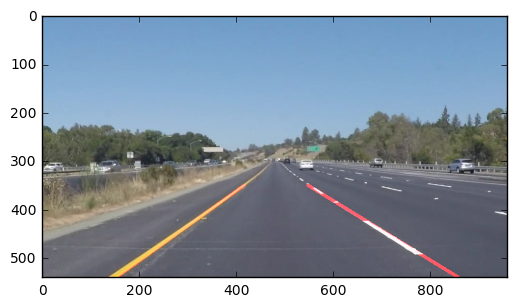

In [28]:
# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1, β=1, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """   
    
    return cv2.addWeighted(initial_img, α, img, β, λ)


############## UNIT TEST ##############
test_hough = hough_lines(test_image)
test_weighted = weighted_img(test_hough, test_image)
print("masked_edges shape {}".format(test_weighted.shape))
plt.imshow(test_weighted)
######################

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [29]:
import os
#os.listdir("test_images/")

run your solution on all test_images and make copies into the test_images directory).

In [30]:
"""
    Collects test images, creates folder to put them in, runs pipeline, and saves images.
"""

import os
import shutil

test_images = os.listdir("test_images/")

try:
    processed_images = os.listdir("test_images/processed_images/")
except FileNotFoundError:
    print("File not found")
    
if processed_images:
    shutil.rmtree("test_images/processed_images/", ignore_errors=True)
    #Create New Folder for Processing
    create_success = os.mkdir("test_images/processed_images/")

for img in test_images:
    if '.jpg' in img:
        image = mpimg.imread("test_images/%(filename)s" % {"filename": img})
        
        hough = hough_lines(image)    
        processed_image = weighted_img(hough, image)
        color_fix = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        
        cv2.imwrite("test_images/processed_images/%(filename)s_processed.jpg" % 
                                    {"filename": img.replace(".jpg","")}, color_fix)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [31]:
import imageio
imageio.plugins.ffmpeg.download()

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
    
def process_image(image):
        hough = hough_lines(image)
        result = weighted_img(hough, image)

        return result

Let's try the one with the solid white lane on the right first ...

In [34]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 38.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 5.53 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [36]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:15<00:00, 39.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 16.2 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

How could you imagine making your algorithm better / more robust?

-Better understanding of parameters of existing functions
-Approaching more from a probabilistic standpoint (ie Bayes, or some kind of Machine learning)
-More pre-processsing
-Less reliance on "after effects" such as the frame dropping and averaging
-Hardware approach (multiple cameras, sensor fusion, etc.)

Where will your current algorithm be likely to fail?

Some thoughts:
-At intersections (no lane markings)
-At sharp turns (constrained masking area)
-In poor weather (general sensitivity)
-During lane changes (change in angle of car)
-Emergency (sudden change in envrionment)
-Poorly marker lanes
-Lanes marked by reflective light points at night



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [38]:
def process_image2(image, rho=1, theta=np.pi/180, threshold=100, min_line_len=0, max_line_gap=0):
        hough = hough_lines(image)
        result = weighted_img(hough, image)

        return result

challenge_output = 'extra1.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra1.mp4
[MoviePy] Writing video extra1.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

UnboundLocalError: local variable 'right_top_x' referenced before assignment

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))